# Extract features from T5 WSG Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from collections import OrderedDict

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# T5 BA + WSG PvL

In [3]:
data = pd.read_csv('T5_WSG_BA_PvL.csv', index_col = 0)
data = data.T
data

,Treatment,s_Pseudobutyrivibrio_ruminis,s_Parabacteroides_goldsteinii,s_Lactobacillus_reuteri,s_Lactobacillus_murinus,s_Lactobacillus_johnsonii,s_Lactobacillus_gasseri,s_Lactobacillus_animalis,s_Lachnospiraceae_bacterium_14-2,s_Akkermansia_muciniphila,...,Ursocholic acid.2,Ursocholic acid.3,Ursocholic acid.4,Ursocholic acid.5,Ursocholic acid.6,Ursocholic acid.7,Ursodeoxycholic acid,Ursodeoxycholic acid.1,Ursodeoxycholic acid.2,Ursodeoxycholic acid.3
T5_570,0,26,39,2199,221,1148,978,58,67,8181,...,0,0,0,0,0,0,0,0,0,0
T5_571,0,59,21,14421,476,1834,1072,119,110,4851,...,0,0,0,0,0,0,0,0,0,0
T5_572,0,153,115,15827,200,1983,1216,63,122,13613,...,0,0,0,0,0,0,7114,0,0,0
T5_573,0,24,51,61204,251,7940,3590,62,49,20925,...,0,0,0,0,0,0,0,0,0,0
T5_574,0,33,39,4736,288,1338,903,85,56,4154,...,0,0,0,0,0,0,0,0,0,0
T5_575,0,20,34,14042,350,2367,1420,98,35,4185,...,0,0,0,0,0,0,0,0,0,0
T5_576,0,21,42,7895,385,1258,1017,141,91,3007,...,0,0,0,0,0,0,0,0,27155,0
T5_577,0,40,17,2017,131,862,640,41,401,2637,...,0,0,0,0,0,0,0,0,26857,0
T5_578,1,13,93,5335,194,1306,930,66,73,3975,...,0,0,0,0,53690,0,0,0,0,0
T5_580,1,115,97,112840,318,14540,4536,103,129,88167,...,0,0,0,0,0,0,0,0,0,0


In [4]:
y = data.iloc[:,0]
x = data.iloc[:,1:200]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.35, random_state=7)

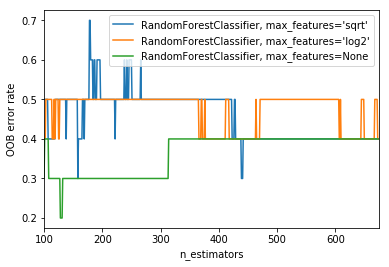

In [6]:
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt", 
                               random_state=42)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True, 
                               random_state=42)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True, 
                               random_state=42))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 100
max_estimators = 675

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [8]:
clf = RandomForestClassifier(n_estimators=200, max_features=None, random_state=41)
all_accuracies = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5)
print('Mean Validation Scores: ' ,end='')
print(np.mean(all_accuracies))

Mean Validation Scores: 0.9


In [9]:
clf_final = RandomForestClassifier(n_estimators=200, max_features=None, oob_score=True, random_state=27)
clf_final.fit(X_train,y_train)
y_pred = clf_final.predict(X_test)
print("Test Set Accuracy:",metrics.accuracy_score(y_test, y_pred))

Test Set Accuracy: 0.8333333333333334


In [22]:
# clf_final = RandomForestClassifier(n_estimators=100, max_features=None, oob_score=True, random_state=27)
# clf_final.fit(X_train,y_train)
# y_pred = clf_final.predict(X_test)
# print("Test Set Accuracy:",metrics.accuracy_score(y_test, y_pred))

Test Set Accuracy: 0.8333333333333334


In [10]:
rf_probs = clf_final.predict_proba(X_test)[:, 1]
roc_value = roc_auc_score(y_test, rf_probs)
roc_value

0.7777777777777779

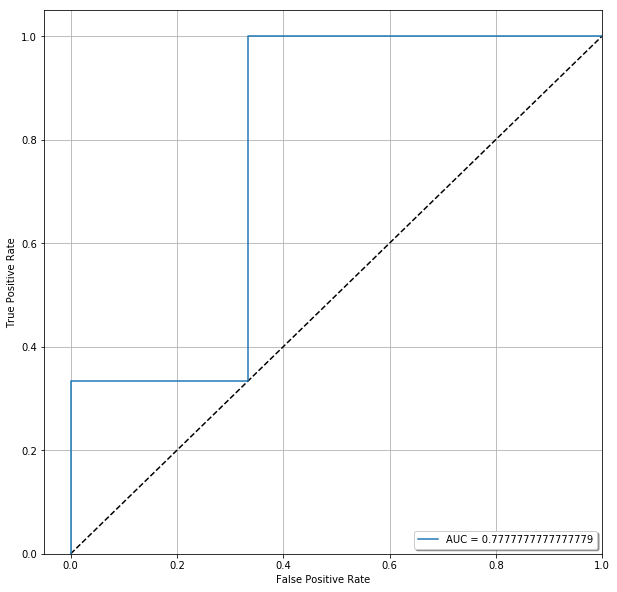

In [11]:
# get roc/auc info
Y_score = clf_final.predict_proba(X_test)[:,1]
fpr = dict()
tpr = dict()
fpr, tpr, _ = roc_curve(y_test, Y_score)

roc_auc = dict()
roc_auc = auc(fpr, tpr)

# make the plot
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))        
plt.legend(loc="lower right", shadow=True, fancybox =True) 
plt.show()

In [12]:
print(clf_final.oob_score_)

0.6


In [13]:
feature_importance = pd.Series(clf_final.feature_importances_).sort_values(ascending=False)
feats = feature_importance[0:20]
feats.index

Int64Index([19, 18, 1, 2, 112, 5, 104, 12, 8, 106, 20, 58, 4, 100, 147, 16, 10,
            3, 107, 23],
           dtype='int64')

In [14]:
features = []
WGS = 0
BA = 0
for i in feats.index:
    features.append(x.iloc[:,i].name)
    if i <= 26:
         WGS += 1
    else: 
        BA +=1
print(WGS)
print(BA)

13
7


In [15]:
for i in feats.values:
    print(i)

0.245
0.085
0.075
0.065
0.065
0.06
0.05
0.04
0.04
0.03
0.03
0.025
0.02
0.015
0.015
0.015
0.01
0.01
0.01
0.01


In [16]:
features

['s_Candidatus_Arthromitus_sp._SFB-mouse',
 's_Candidatus_Arthromitus_sp._SFB-mouse-NL',
 's_Parabacteroides_goldsteinii',
 's_Lactobacillus_reuteri',
 '12-Ketodeoxycholic acid (NIST14).2',
 's_Lactobacillus_gasseri',
 'Cholic acid methyl ester',
 's_Paenibacillus_sp._IHB_B_3084',
 's_Akkermansia_muciniphila',
 'Cholic acid methyl ester.2',
 's_Acetobacter_sp._SLV-7',
 'β-Muricholic acid.3',
 's_Lactobacillus_johnsonii',
 'Cholic acid.8',
 'Deoxycholic acid (NIST14).1',
 's_Lactobacillus_amylolyticus',
 's_Vibrio_sp._2521-89',
 's_Lactobacillus_murinus',
 'Deoxycholic acid',
 's_Entomoplasma_freundtii']

# T5 Metabolome + WSG PvL

In [22]:
data = pd.read_csv('T5_Known_WSG_PvL.csv', index_col = 0)
data = data.T
data

,Treatment,s_Pseudobutyrivibrio_ruminis,s_Parabacteroides_goldsteinii,s_Lactobacillus_reuteri,s_Lactobacillus_murinus,s_Lactobacillus_johnsonii,s_Lactobacillus_gasseri,s_Lactobacillus_animalis,s_Lachnospiraceae_bacterium_14-2,s_Akkermansia_muciniphila,...,5-Hexenoic acid,4-Cholestenone,3β -Hydroxy-5-cholestenoic acid,3-Hydroxykynurenine,25(S)-26-Hydroxycholesterol,17-Octadecynoic acid,1-Palmitoyl-sn-glycero-3-phosphocholine,1-Palmitoyl-sn-glycero-3-phosphocholine.1,1-Hexadecyl-sn-glycero-3-phosphocholine,(+)-Fluprostenol lactone diol
T5_570,0,26,39,2199,221,1148,978,58,67,8181,...,0,0,0,15149,0,0,69196,0,0,0
T5_571,0,59,21,14421,476,1834,1072,119,110,4851,...,0,0,0,0,0,0,54981,0,0,0
T5_572,0,153,115,15827,200,1983,1216,63,122,13613,...,0,3457,0,0,0,0,117275,0,0,0
T5_573,0,24,51,61204,251,7940,3590,62,49,20925,...,0,0,0,0,0,0,35704,0,0,0
T5_574,0,33,39,4736,288,1338,903,85,56,4154,...,0,0,0,109892,0,0,63940,0,3858,0
T5_575,0,20,34,14042,350,2367,1420,98,35,4185,...,0,0,0,52032,0,0,76174,0,2462,0
T5_576,0,21,42,7895,385,1258,1017,141,91,3007,...,0,0,0,0,0,0,56964,0,0,0
T5_577,0,40,17,2017,131,862,640,41,401,2637,...,0,0,0,0,0,0,27484,0,0,0
T5_578,1,13,93,5335,194,1306,930,66,73,3975,...,0,0,0,4007,1781,0,110207,4119,0,0
T5_580,1,115,97,112840,318,14540,4536,103,129,88167,...,0,0,0,0,0,0,38557,0,0,0


In [23]:
y = data.iloc[:,0]
x = data.iloc[:,1:100]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.35, random_state=11)

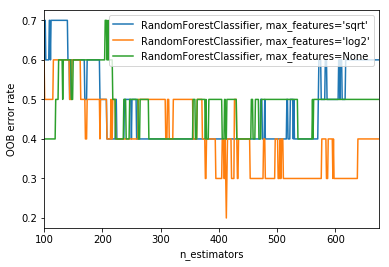

In [25]:
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt", 
                               random_state=42)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True, 
                               random_state=42)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True, 
                               random_state=42))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 100
max_estimators = 675

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [36]:
clf = RandomForestClassifier(n_estimators=550, max_features='log2',random_state=10)
all_accuracies = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5)
print('Mean Validation Scores: ' ,end='')
print(np.mean(all_accuracies))

Mean Validation Scores: 0.8


In [82]:
clf_final = RandomForestClassifier(n_estimators=550, max_features='log2', oob_score=True,random_state=59)
clf_final.fit(X_train,y_train)
y_pred = clf_final.predict(X_test)
print("Test Set Accuracy:",metrics.accuracy_score(y_test, y_pred))

Test Set Accuracy: 0.8333333333333334


In [83]:
# clf_final = RandomForestClassifier(n_estimators=300, max_features='log2', oob_score=True,random_state=26)
# clf_final.fit(X_train,y_train)
# y_pred = clf_final.predict(X_test)
# print("Test Set Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [84]:
rf_probs = clf_final.predict_proba(X_test)[:, 1]
roc_value = roc_auc_score(y_test, rf_probs)
roc_value

0.888888888888889

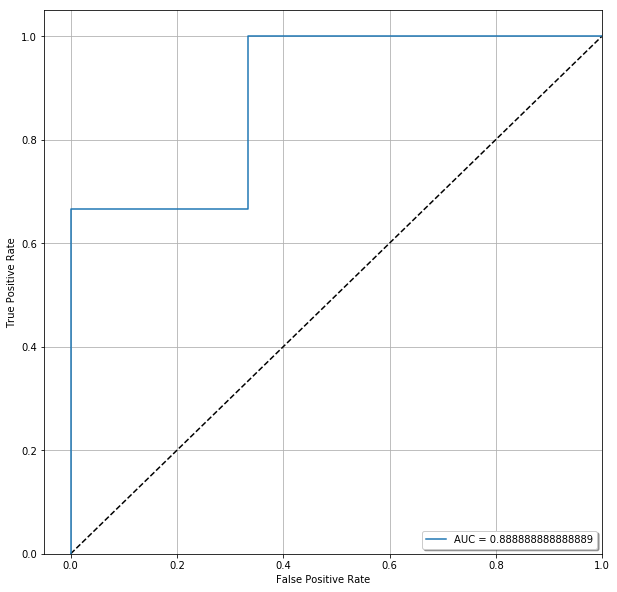

In [85]:
# get roc/auc info
Y_score = clf_final.predict_proba(X_test)[:,1]
fpr = dict()
tpr = dict()
fpr, tpr, _ = roc_curve(y_test, Y_score)

roc_auc = dict()
roc_auc = auc(fpr, tpr)

# make the plot
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))        
plt.legend(loc="lower right", shadow=True, fancybox =True) 
plt.show()

In [86]:
print(clf_final.oob_score_)

0.6


In [87]:
feature_importance = pd.Series(clf_final.feature_importances_).sort_values(ascending=False)
feats = feature_importance[0:20]
feats.index

Int64Index([5, 75, 2, 23, 1, 19, 4, 10, 25, 18, 84, 8, 15, 68, 12, 20, 16, 3,
            17, 0],
           dtype='int64')

In [88]:
features = []
WGS = 0
Meta = 0
for i in feats.index:
    features.append(x.iloc[:,i].name)
    if i <= 26:
         WGS += 1
    else: 
        Meta +=1
print(WGS)
print(Meta)

17
3


In [89]:
for i in feats.values:
    print(i)

0.054588924963924985
0.047087786023500305
0.043220057720057714
0.04143217893217893
0.041286075036075044
0.039095238095238107
0.03740187590187591
0.037346849446849434
0.03712521645021644
0.034681072631072625
0.031193903318903315
0.0266029341029341
0.02444761904761904
0.024396103896103895
0.02234018759018759
0.021336796536796532
0.021334054834054837
0.02110286538857967
0.019982251082251084
0.019810606060606063


In [90]:
features

['s_Lactobacillus_gasseri',
 'Bacosine',
 's_Lactobacillus_reuteri',
 's_Entomoplasma_freundtii',
 's_Parabacteroides_goldsteinii',
 's_Candidatus_Arthromitus_sp._SFB-mouse',
 's_Lactobacillus_johnsonii',
 's_Vibrio_sp._2521-89',
 's_Bifidobacterium_pseudolongum',
 's_Candidatus_Arthromitus_sp._SFB-mouse-NL',
 '1-Palmitoyl-sn-glycero-3-phosphocholine',
 's_Akkermansia_muciniphila',
 's_Bacteroides_vulgatus',
 'Coproporphyrin I',
 's_Paenibacillus_sp._IHB_B_3084',
 's_Acetobacter_sp._SLV-7',
 's_Lactobacillus_amylolyticus',
 's_Lactobacillus_murinus',
 's_Lactobacillus_acidophilus',
 's_Pseudobutyrivibrio_ruminis']

# T5 BA + WSG LvCoL

In [91]:
data = pd.read_csv('T5_WSG_BA_LvCoL.csv', index_col = 0)
data = data.T
data

,Treatment,s_Pseudobutyrivibrio_ruminis,s_Parabacteroides_goldsteinii,s_Lactobacillus_reuteri,s_Lactobacillus_murinus,s_Lactobacillus_johnsonii,s_Lactobacillus_gasseri,s_Lactobacillus_animalis,s_Lachnospiraceae_bacterium_14-2,s_Akkermansia_muciniphila,...,Ursocholic acid.2,Ursocholic acid.3,Ursocholic acid.4,Ursocholic acid.5,Ursocholic acid.6,Ursocholic acid.7,Ursodeoxycholic acid,Ursodeoxycholic acid.1,Ursodeoxycholic acid.2,Ursodeoxycholic acid.3
T5_578,0,13,93,5335,194,1306,930,66,73,3975,...,0,0,0,0,53690,0,0,0,0,0
T5_580,0,115,97,112840,318,14540,4536,103,129,88167,...,0,0,0,0,0,0,0,0,0,0
T5_581,0,20,111,55887,576,5008,1925,213,91,24424,...,0,0,0,0,0,0,0,0,53377,0
T5_582,0,11,197,51127,338,3590,2065,87,56,44874,...,0,0,0,0,0,0,0,0,54155,30116
T5_583,0,4,118,3723,124,1468,1115,43,47,99117,...,0,0,0,0,0,0,0,0,0,0
T5_584,0,222,94,43792,299,3015,1607,91,81,6903,...,0,137207,0,0,0,0,0,0,0,0
T5_585,0,1214,35,36821,44,2936,1686,8,496,3526,...,0,0,0,0,0,0,0,0,34302,0
T5_586,0,12,56,75536,394,4134,1553,129,32,64129,...,0,0,0,0,0,0,0,0,0,0
T5_589,1,156,142,25356,291,49559,3511,56,48,196076,...,0,0,0,0,0,0,0,0,0,0
T5_591,1,83,60,20048,180,4979,1046,50,73,37521,...,0,0,0,0,0,0,0,0,0,0


In [92]:
y = data.iloc[:,0]
x = data.iloc[:,1:200]

In [93]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.35, random_state=13)

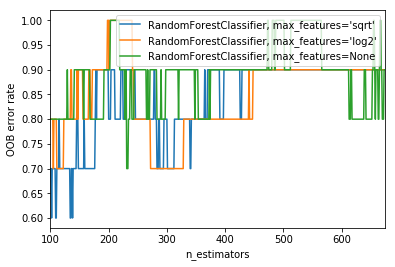

In [94]:
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt", 
                               random_state=42)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True, 
                               random_state=42)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True, 
                               random_state=42))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 100
max_estimators = 675

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [105]:
clf = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=42)
all_accuracies = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5)
print('Mean Validation Scores: ' ,end='')
print(np.mean(all_accuracies))

Mean Validation Scores: 0.5


In [115]:
clf_final = RandomForestClassifier(n_estimators=100, max_features='sqrt', oob_score=True, random_state=1)
clf_final.fit(X_train,y_train)
y_pred = clf_final.predict(X_test)
print("Test Set Accuracy:",metrics.accuracy_score(y_test, y_pred))

Test Set Accuracy: 0.8333333333333334


In [116]:
rf_probs = clf_final.predict_proba(X_test)[:, 1]
roc_value = roc_auc_score(y_test, rf_probs)
roc_value

0.888888888888889

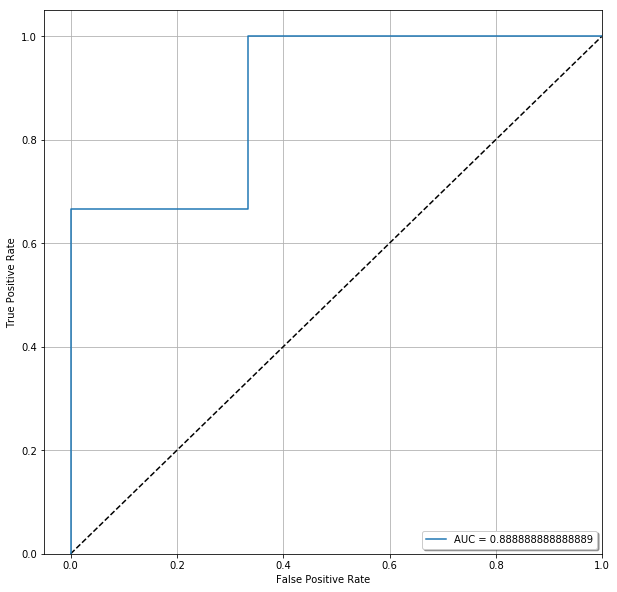

In [118]:
# get roc/auc info
Y_score = clf_final.predict_proba(X_test)[:,1]
fpr = dict()
tpr = dict()
fpr, tpr, _ = roc_curve(y_test, Y_score)

roc_auc = dict()
roc_auc = auc(fpr, tpr)

# make the plot
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))        
plt.legend(loc="lower right", shadow=True, fancybox =True) 
plt.show()

In [119]:
print(clf_final.oob_score_)

0.3


In [120]:
feature_importance = pd.Series(clf_final.feature_importances_).sort_values(ascending=False)
feats = feature_importance[0:20]
feats.index

Int64Index([ 83,  25,  14,  23,  41,  13,   4,   0,   5, 104,  76, 117, 138,
            116, 112,  24,  18, 159,  47, 147],
           dtype='int64')

In [121]:
features = []
WGS = 0
BA = 0
for i in feats.index:
    features.append(x.iloc[:,i].name)
    if i <= 26:
         WGS += 1
    else: 
        BA +=1
print(WGS)
print(BA)

9
11


In [112]:
for i in feats.values:
    print(i)

0.045714285714285714
0.03251984126984127
0.03226190476190476
0.030674603174603167
0.029523809523809525
0.02900793650793651
0.028571428571428577
0.028299319727891157
0.028055555555555552
0.02435185185185185
0.022777777777777772
0.022738095238095238
0.022261904761904764
0.022222222222222223
0.021507936507936507
0.02
0.019365079365079363
0.019357142857142857
0.019345238095238092
0.019166666666666665


In [122]:
features

['γ-Muricholic acid.13',
 's_Bifidobacterium_pseudolongum',
 's_Borrelia_anserina',
 's_Entomoplasma_freundtii',
 'β-Hyodeoxycholic acid.7',
 's_Corynebacterium_uterequi',
 's_Lactobacillus_johnsonii',
 's_Pseudobutyrivibrio_ruminis',
 's_Lactobacillus_gasseri',
 'Cholic acid methyl ester',
 'γ-Muricholic acid.6',
 '3β-Hydroxy-5-cholenoic acid (NIST14).1',
 'Cholic acid (NIST14).14',
 '3β-Hydroxy-5-cholenoic acid (NIST14)',
 '12-Ketodeoxycholic acid (NIST14).2',
 's_Chlamydia_caviae',
 's_Candidatus_Arthromitus_sp._SFB-mouse-NL',
 'Lithocholic acid (NIST14)',
 'β-Hyodeoxycholic acid.13',
 'Deoxycholic acid (NIST14).1']

# T5 Metabolome + WSG LvCoL

In [123]:
data = pd.read_csv('T5_Known_WSG_LvCoL.csv', index_col = 0)
data = data.T
data

,Treatment,s_Pseudobutyrivibrio_ruminis,s_Parabacteroides_goldsteinii,s_Lactobacillus_reuteri,s_Lactobacillus_murinus,s_Lactobacillus_johnsonii,s_Lactobacillus_gasseri,s_Lactobacillus_animalis,s_Lachnospiraceae_bacterium_14-2,s_Akkermansia_muciniphila,...,5-Hexenoic acid,4-Cholestenone,3β -Hydroxy-5-cholestenoic acid,3-Hydroxykynurenine,25(S)-26-Hydroxycholesterol,17-Octadecynoic acid,1-Palmitoyl-sn-glycero-3-phosphocholine,1-Palmitoyl-sn-glycero-3-phosphocholine.1,1-Hexadecyl-sn-glycero-3-phosphocholine,(+)-Fluprostenol lactone diol
T5_578,0,13,93,5335,194,1306,930,66,73,3975,...,0,0,0,4007,1781,0,110207,4119,0,0
T5_580,0,115,97,112840,318,14540,4536,103,129,88167,...,0,0,0,0,0,0,38557,0,0,0
T5_581,0,20,111,55887,576,5008,1925,213,91,24424,...,0,0,0,0,0,0,43303,2509,22402,0
T5_582,0,11,197,51127,338,3590,2065,87,56,44874,...,0,0,0,0,0,0,31460,0,0,0
T5_583,0,4,118,3723,124,1468,1115,43,47,99117,...,0,0,0,0,0,0,40654,0,0,0
T5_584,0,222,94,43792,299,3015,1607,91,81,6903,...,0,0,0,131702,0,0,55547,3811,0,0
T5_585,0,1214,35,36821,44,2936,1686,8,496,3526,...,8036,0,0,0,0,0,49294,3285,0,0
T5_586,0,12,56,75536,394,4134,1553,129,32,64129,...,0,0,0,0,0,0,186922,0,0,0
T5_589,1,156,142,25356,291,49559,3511,56,48,196076,...,0,0,0,40749,0,22896,14421,0,5735,0
T5_591,1,83,60,20048,180,4979,1046,50,73,37521,...,7566,4653,0,57597,0,0,88585,1236,0,0


In [124]:
y = data.iloc[:,0]
x = data.iloc[:,1:100]

In [218]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.35, random_state=67)

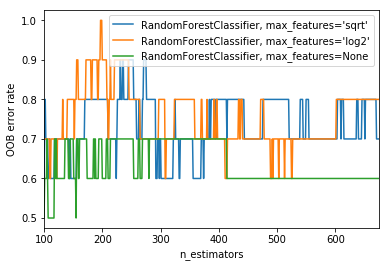

In [219]:
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt", 
                               random_state=42)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True, 
                               random_state=42)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True, 
                               random_state=42))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 100
max_estimators = 675

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [220]:
clf = RandomForestClassifier(n_estimators=500, max_features=None, random_state=41)
all_accuracies = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5)
print('Mean Validation Scores: ' ,end='')
print(np.mean(all_accuracies))

Mean Validation Scores: 0.7


In [264]:
clf_final = RandomForestClassifier(n_estimators=300, max_features=None, oob_score=True, random_state=41)
clf_final.fit(X_train,y_train)
y_pred = clf_final.predict(X_test)
print("Test Set Accuracy:",metrics.accuracy_score(y_test, y_pred))

Test Set Accuracy: 0.8333333333333334


In [265]:
rf_probs = clf_final.predict_proba(X_test)[:, 1]
roc_value = roc_auc_score(y_test, rf_probs)
roc_value

0.888888888888889

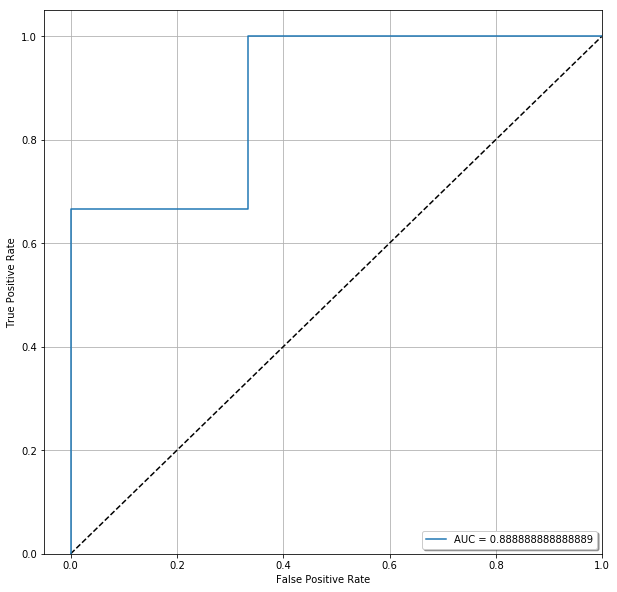

In [266]:
# get roc/auc info
Y_score = clf_final.predict_proba(X_test)[:,1]
fpr = dict()
tpr = dict()
fpr, tpr, _ = roc_curve(y_test, Y_score)

roc_auc = dict()
roc_auc = auc(fpr, tpr)

# make the plot
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))        
plt.legend(loc="lower right", shadow=True, fancybox =True) 
plt.show()

In [267]:
print(clf_final.oob_score_)

0.5


In [268]:
feature_importance = pd.Series(clf_final.feature_importances_).sort_values(ascending=False)
feats = feature_importance[0:20]
feats.index

Int64Index([13, 84, 71, 57, 64, 27, 63, 5, 37, 81, 2, 10, 24, 52, 22, 14, 77,
            18, 38, 6],
           dtype='int64')

In [269]:
features = []
WGS = 0
Meta = 0
for i in feats.index:
    features.append(x.iloc[:,i].name)
    if i <= 26:
         WGS += 1
    else: 
        Meta +=1
print(WGS)
print(Meta)

9
11


In [270]:
features

['s_Corynebacterium_uterequi',
 '1-Palmitoyl-sn-glycero-3-phosphocholine',
 'cis-5,8,11,14-Eicosatetraenoic acid.1',
 '1-Phenanthrenecarboxylic acid.1',
 'Hederagenin',
 'Sumaresinolic acid',
 'Linoleic acid methyl ester',
 's_Lactobacillus_gasseri',
 'phosphoethanolamine (NIST14)',
 '3-Hydroxykynurenine',
 's_Lactobacillus_reuteri',
 's_Vibrio_sp._2521-89',
 's_Chlamydia_caviae',
 'Oleanolic acid methyl ester',
 's_Faecalibaculum_rodentium',
 's_Borrelia_anserina',
 '9-Oxo-10E,12Z-octadecadienoic acid',
 's_Candidatus_Arthromitus_sp._SFB-mouse-NL',
 'phosphocholine (NIST14)',
 's_Lactobacillus_animalis']

In [271]:
for i in feats.values:
    print(i)

0.15333333333333332
0.13666666666666666
0.10555555555555554
0.04666666666666667
0.04333333333333333
0.04
0.03880952380952381
0.029166666666666667
0.028888888888888895
0.028888888888888895
0.028888888888888888
0.023333333333333334
0.022222222222222223
0.021190476190476194
0.02
0.018888888888888886
0.016666666666666666
0.016666666666666666
0.016666666666666666
0.016666666666666666
